# Noisy QITE
This notebook is a guide to implement QITE on multiple qubits, with noise

We will refer to Pauli matrices by their indices: $[I, X, Y, Z] \equiv [0, 1, 2, 3]$
For consistency in notation, we use the following mapping for n-qubit operators, composed of a Pauli matrices acting on each qubit. This is the indexing used throughout the code.

In [1]:
# nqbits = 2
pauli_indices = [0, 1, 2, 3]
pauli_pairs = [(i, j) for i in pauli_indices for j in pauli_indices]
print(pauli_pairs)
pauli_pair_dict = {pauli_pairs[i] : i for i in range(len(pauli_pairs))}
print(pauli_pair_dict)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]
{(0, 0): 0, (0, 1): 1, (0, 2): 2, (0, 3): 3, (1, 0): 4, (1, 1): 5, (1, 2): 6, (1, 3): 7, (2, 0): 8, (2, 1): 9, (2, 2): 10, (2, 3): 11, (3, 0): 12, (3, 1): 13, (3, 2): 14, (3, 3): 15}


In [2]:
# II, YZ, ZY, XI, IX, XX, YY, ZZ
reduced_ops = [(0,0),(2,3),(3,2),(1,0),(0,1),(1,1),(2,2),(3,3)]
reduced_ops_i = [pauli_pair_dict[pair] for pair in reduced_ops]
print(reduced_ops)
print(reduced_ops_i)
# print(index[14,5])

[(0, 0), (2, 3), (3, 2), (1, 0), (0, 1), (1, 1), (2, 2), (3, 3)]
[0, 11, 14, 4, 1, 5, 10, 15]


## Measure the Pauli Expectations

In **measure** we define circuits to measure the expectation value of any Pauli string. Read more: https://docs.microsoft.com/en-us/quantum/concepts/pauli-measurements

In [3]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, BasicAer, IBMQ
from qiskit.compiler import transpile
# for noise mitigation
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [4]:
# Circuit to measure the expectation value of any Pauli string
# For 2-qubit Pauli measurements, see https://docs.microsoft.com/en-us/quantum/concepts/pauli-measurements
def measure_pauli_expectations(qbackend, qc, qbits, idx, shots=8192, noise=False):
    '''
    Compute multi-qubit Pauli expectations by changing Pauli measurements to a 
    diagonal ({Z, I}^n) basis
    '''
    # variable to return
    pauli_expectation = 1
    # for circuit transpilation
    # qbackend basis gates
    basis_gates = qbackend.configuration().basis_gates
    # qbackend coupling map
    coupling_map = qbackend.configuration().coupling_map
    
    # initialize counts dict
    counts = {}
    
    # start measurement 
    nqbits = len(qbits)
    idx_pair = list(pauli_pairs[idx])
    
    # I x I ....
    cond1 = [0] * nqbits
    # Z x I ....
    cond2 = [3] + [0] * (nqbits - 1)
    
    # if I x I .... or Z x I .... just return the expectation is 1
    if idx_pair == cond1:
        return 1
    
    elif idx_pair == cond2:
        pass
    
    # Step 1. convert multi qubit operator (Pauli string) to Z x I ... basis
    # if zero qubit Pauli gate is I, swap 0 qubit with first qubit with non-identity Pauli gate 
    # for example, I X Y Z -> X I Y Z
    if idx_pair[0] == 0:
        # get first qubit acted on by Pauli matrix other than I
        for j in range(1,len(idx_pair)):
            if idx_pair[j] != 0:
                qc.swap(qbits[0],qbits[j])
                idx_pair[0], idx_pair[j] = idx_pair[j], idx_pair[0]
                break

    # cnot_list keeps track of the qubits q to apply cnot gate between zero qubit and q... qc.cx(q,0)
    cnot_list = [-1] + qbits[1:]

    # proceed to implement the change of basis by applying unitaries
    for i in range(nqbits):
        # I
        if idx_pair[i] == 0:
            cnot_list[i] = -1
        # X
        elif idx_pair[i] == 1:
            qc.h(qbits[i])
        # Y
        elif idx_pair[i] == 2:
            qc.rx(np.pi/2,qbits[i])
        # Z
        elif idx_pair[i] == 3:
            pass
        else:
            raise ValueError

    # entangle by apply CNOT gates between all qubits acted on by Pauli matrix other than I and 0 qubit
    for q in cnot_list:
        if q != -1:
            qc.cx(q, qbits[0])

    # add noise model
    if noise:
        # entangle for simultaneous measurement of pauli string expectation and parity
        for i in range(nqbits-1):
            qc.cx(qbits[i],qbits[i+1])
        
        # Step 2: measure
        qc.measure(qc.qregs[0],qc.cregs[0])
        
        # Build noise model from backend properties
        noise_backend = provider.get_backend('ibmq_london')
        noise_model = NoiseModel.from_backend(noise_backend)

        # Get coupling map from noise backend
        noise_coupling_map = noise_backend.configuration().coupling_map

        # Get basis gates from noise model
        noise_basis_gates = noise_model.basis_gates
        
        # execute a noisy simulation
        job = execute(qc, qbackend,
            coupling_map=noise_coupling_map,
            basis_gates=noise_basis_gates,
            noise_model=noise_model,
            shots=shots,
            optimization_level=optimization_level)

        results = job.result()
        
        # Readout error mitigation: https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html
        # create set of circuits to take measurements for each of the 2^nqbits basis states
        meas_calibs, state_labels = complete_meas_cal(qr=QuantumRegister(2), circlabel='mcal')
        
        # get calibration fitter and calibration matrix
        job_cal = execute(meas_calibs, backend=qbackend,
                coupling_map=noise_coupling_map,
                basis_gates=noise_basis_gates,
                noise_model=noise_model,
                shots=shots,
                optimization_level=optimization_level)
        
        cal_results = job_cal.result()
        
        meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
        
        # get the filter object
        meas_filter = meas_fitter.filter
        
        # get the results with noise mitigation
        mitigated_results = meas_filter.apply(results)
        
        mitigated_counts = mitigated_results.get_counts(0)
        counts = mitigated_counts
        
        if '00' not in counts:
            counts['00'] = 0
        if '11' not in counts:
            counts['11'] = 0
        if '01' not in counts:
            counts['01'] = 0
        if '10' not in counts:
            counts['10'] = 0
        pauli_expectation = (counts['00'] - counts['11']) / (counts['00'] + counts['11'])
        
    # just transpile circuit
    else:
        # Step 2: measure the 0 qubit
        qc.measure(qc.qregs[0][0],qc.cregs[0])
        
        # transpile circuit to adapt to qbackend
        qc_transpiled = transpile(qc, backend=qbackend, basis_gates=basis_gates, coupling_map=coupling_map)
        job = execute(qc_transpiled, qbackend, shots=shots, optimization_level=optimization_level)
        counts = job.result().get_counts()

        if '0' not in counts:
            counts['0'] = 0
        if '1' not in counts:
            counts['1'] = 0
        pauli_expectation = (counts['0'] - counts['1']) / shots
    
    return pauli_expectation


## Propagate the State

In **propagate**, we loop through the different values store in alist to construct the states. alist is stored as a list of lists and the indices are $a[timestep][gate]$. For a timestep $\Delta \tau$, the gate indices of $a$ correspond to:

$$
a[0]=e^{-ia[II]\Delta\tau\hat{I} \otimes \hat{I}} \text{,  } \; 
a[1]=e^{-ia[IX]\Delta\tau\hat{I} \otimes \hat{X}} \text{,  } \;
a[2]=e^{-ia[IY]\Delta\tau\hat{I} \otimes \hat{Y}} \text{,  } \;
a[3]=e^{-ia[ZZ]\Delta\tau\hat{I} \otimes \hat{Z}}
$$
$$
a[4]=e^{-ia[XI]\Delta\tau\hat{X} \otimes \hat{I}} \text{,  } \; 
a[5]=e^{-ia[XX]\Delta\tau\hat{X} \otimes \hat{X}} \text{,  } \;
a[6]=e^{-ia[XY]\Delta\tau\hat{X} \otimes \hat{Y}} \text{,  } \;
a[7]=e^{-ia[XZ]\Delta\tau\hat{X} \otimes \hat{Z}}
$$
$$
a[8]=e^{-ia[YI]\Delta\tau\hat{Y} \otimes \hat{I}} \text{,  } \; 
a[9]=e^{-ia[YX]\Delta\tau\hat{Y} \otimes \hat{X}} \text{,  } \;
a[10]=e^{-ia[YY]\Delta\tau\hat{Y} \otimes \hat{Y}} \text{,  } \;
a[11]=e^{-ia[YZ]\Delta\tau\hat{Y} \otimes \hat{Z}}
$$
$$
a[12]=e^{-ia[ZI]\Delta\tau\hat{Z} \otimes \hat{I}} \text{,  } \; 
a[13]=e^{-ia[ZX]\Delta\tau\hat{Z} \otimes \hat{X}} \text{,  } \;
a[14]=e^{-ia[ZY]\Delta\tau\hat{Z} \otimes \hat{Y}} \text{,  } \;
a[15]=e^{-ia[ZZ]\Delta\tau\hat{Z} \otimes \hat{Z}}
$$

The 0 index stores the coefficient for the identity matrix $\hat{I}$ on both qubits, which is a global phase for each qubit that we can ignore.

We can break down the matrix exponential of the Kronecker product of two Pauli matrices as:

$$e^{-i \theta \Delta\tau \bigotimes_{j} \sigma_{j}} = \cosh(-i \theta \Delta\tau) \bigotimes_{j} I + \sinh(-i \theta \Delta\tau) \bigotimes_{j} \sigma_{j} = \cos(\theta \Delta\tau) \bigotimes_{j} I - i \sin(\theta \Delta\tau) \bigotimes_{j} \sigma_{j}$$

For example,

$$e^{-ia[XY]\Delta\tau\hat{X} \otimes \hat{Y}} = \cos(a[XY] \Delta\tau) (I \otimes I) - i \sin(a[XY] \Delta\tau) (X \otimes Y)$$

To implement this in terms of gates on a quantum computer, refer to page 210 in Nielsen and Chuang: http://mmrc.amss.cas.cn/tlb/201702/W020170224608149940643.pdf

We need to apply a phase shift to the system. Phase is $e^{-i \Delta \tau}$ if the parity of the $n$ qubits in the computational basis is even, and $e^{i \Delta \tau}$ if odd. For 2 qubits, this is the matrix exponential of $i \Delta \tau Z \otimes Z$

$$ e^{-i \Delta \tau Z \otimes Z} =
\begin{pmatrix}
e^{-i \Delta \tau} & 0 & 0 & 0\\
0 & e^{i \Delta \tau} & 0 & 0\\
0 & 0 & e^{i \Delta \tau} & 0\\
0 & 0 & 0 & e^{-i \Delta \tau}\\
\end{pmatrix}
$$

The function **applyPhase** implements this $e^{-i \Delta \tau Z \otimes Z}$ operation

In [5]:
def applyPhase(qc,qbits,angle, id_idx_list):
    a = list(range(0,len(qbits)-1))
    b = id_idx_list
    
    # c is qubits [0, ..., nqbits-2] excluding qubits acted on by I (where we do nothing)
    c = list(set(a).difference(set(b)))
    
    # apply the cnot gates between all qubits in c and last qubit, qubit (nqbits-1)
    for i in c:
        qc.cx(qbits[i],qbits[-1])
        
    # z rotation on last qubit
    qc.rz(angle,qbits[-1])
    
    # apply the cnot gates between all qubits in c and last qubit, qubit (nqbits-1)
    c.reverse()
    for i in c:
        qc.cx(qbits[i],qbits[-1])

In [6]:
def propagate(qc,qbits,alist):
    nqbits = len(qbits)
    # Circuit to propagate the state
    if len(alist) == 0:
        None
    else:
        for t in range(len(alist)):
#             for i in range(len(reduced_ops[:3])):
            for i in range(len(reduced_ops)):
                angle = np.real(alist[t][i])
                idx_pair = reduced_ops[i]
                
                # single qubit rotation case... all qubits acted on by I except for one
                nonzero_count = 0
                single_rot_q = -1
                for j in range(len(idx_pair)):
                    if idx_pair[j] != 0:
                        nonzero_count += 1
                        single_rot_q = j
                    if nonzero_count > 1:
                        single_rot_q = -1
                        break   
                
                if single_rot_q != -1:
                    if idx_pair[single_rot_q] == 1:
                        qc.rx(angle,qbits[single_rot_q])
                    elif idx_pair[single_rot_q] == 2:
                        qc.ry(angle,qbits[single_rot_q])
                    elif idx_pair[single_rot_q] == 3:
                        qc.rz(angle,qbits[single_rot_q])
                
                # multi-qubit rotation
                else:
                    id_idx_list = []
                    for j in range(len(idx_pair)):
                        if idx_pair[j] == 0:
                            id_idx_list.append(j)
                        elif idx_pair[j] == 1:
                            qc.h(qbits[j])
                        elif idx_pair[j] == 2:
                            qc.rx(np.pi/2, qbits[j])
                        elif idx_pair[j] == 3:
                            pass
                        else:
                            raise ValueError
                            
                    # maybe skip the CNOT on qubits acted on by I?
                    applyPhase(qc,qbits,angle, id_idx_list)

                    # apply conjugate transpose
                    for j in range(len(idx_pair)):
                        if idx_pair[j] == 0:
                            pass
                        elif idx_pair[j] == 1:
                            qc.h(qbits[j])
                        elif idx_pair[j] == 2:
                            qc.rx(-np.pi/2, qbits[j])
                        elif idx_pair[j] == 3:
                            pass
                        else:
                            raise ValueError

## Update Rotation Angles For Unitary Imaginary Time Evolution

We denote **alist** as $a[m]$, the matrix of rotations per imaginary time step for our unitary operator that recreates imaginary time evolution. Recall:

$$ A[m] = \sum_{i_{1} \ldots i_{k}} a[m]_{i_{1} \ldots i_{k}} \sigma_{i_{1}} \ldots \sigma_{i_{k}} \equiv \sum_{I} a[m]_{I} \sigma_{I}$$

The idea behind QITE is to define a unitary operator $e^{-i \Delta \tau A[m]}$ and apply it to a state $| \Psi \rangle$ to reproduce the state:

$$| \Psi' \rangle = c^{-1/2} e^{- \Delta \tau h[m]} | \Psi \rangle$$

We define the distance between the desired and initial states as $| \Delta_{0} \rangle = \left( {| \Psi' \rangle - | \Psi \rangle} \right) /{\Delta \tau}$ and the difference between the evolved and initial states as $| \Delta \rangle = -iA[m] | \Psi \rangle$. The goal is to minimize $\| \Delta_{0} - \Delta \|$. This corresponds to minimizing the quadratic function (from SI of the Motta paper):

$$f \left( a[m] \right) = f_{0} + \sum_{I} b_{I} a[m]_{I} + \sum_{I,J} a[m]_{I} S_{IJ} a[m]_{J}$$
$$f_{0} = \langle \Delta_{0} | \Delta_{0} \rangle \text{,  } S_{IJ} = \langle \Psi | \sigma_{I}^{\dagger} \sigma_{J} | \Psi \rangle \text{,  } b_{I} = i \langle \Psi | \sigma_{I}^{\dagger} | \Delta_{0} \rangle - i \langle \Delta_{0} | \sigma_{I} | \Psi \rangle = -\frac{i}{\sqrt{c}} \langle \Psi | \sigma_{I}^{\dagger} h[m] | \Psi \rangle$$

The minimum is the solution to the linear equation $\left( S + S^{T} \right) a[m] = -b$, which we solve by applying the generalized inverse or via some iterative algorithm.

To compute $S$, we need to the matrix elements:

$$S_{ij} = \langle \psi | Q_{i} Q_{j} | \psi \rangle = \langle \psi | ( \sigma_{i0} \otimes \sigma_{i1} ) ( \sigma_{j0} \otimes \sigma_{j1} ) | \psi \rangle = \langle \psi | \left( \sigma_{i0} \sigma_{j0} \otimes \sigma_{i1} \sigma_{j1} \right) | \psi \rangle$$

To compute $b$, we need the vector elements:
$$b_{i} = i \langle \psi | Q_{i} | \Delta_{0} \rangle - h.c. = i \langle \psi | {( \sigma_{i0} \otimes \sigma_{i1})} | \Delta_{0} \rangle - h.c.$$


These computations are done in the **update_alist** function. But to compute these elements, we first need to compute the 2-qubit Pauli expectations in a state propagated by our unitary imaginary time evolution.

For the 1-qubit case, we need to construct the matrix $S_{ij} = \langle \psi | \sigma_{i} \sigma_{j} | \psi \rangle$ and the vector $b_{i}$. Well, our earlier functions allow us to measure the expectation values of the different pauli matrices. How do we obtain $S_{ij}$ from a list of $\langle \psi | \sigma | \psi \rangle$? We can exploit the fact that up to some coefficients, $\sigma_{i}\sigma_{j} = c_{ij}\sigma_{ij}$. For example, $\sigma_{x}\sigma_{y} = i\sigma_{z}$. We will need a matrix to keep track of what pauli matrix and coefficient we get for $\sigma_{i}\sigma_{j}$. A pragmatic approach is to hard-code these 1-qubit matrix multiplication matrices.

For the 2-qubit case, we can reuse the 1-qubit matrices. For example,
$(X \otimes X) (X \otimes Y) = XX \otimes XY = I \otimes i Z$

Another way is to hard-code the 2-qubit matrices by directly populating the Lie algebra rules, as we do below.

In [7]:
import sys
sys.path.append('classical')

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm 
from binary_functions import Int2Bas,Bas2Int,Opp2Str,Str2Opp
from Pmn import PPmunu

In [9]:
def lie_algebra(mu,nu,n):
    # Return coefficients and index for sigma mu,sigma nu
    index = ''
    coeff = 1
    for i in range(n):
        tmpA,tmpB = PPmunu(mu[i]+nu[i])
        index += tmpA
        coeff *= tmpB
    return coeff,Bas2Int(Str2Opp(index),4)

In [10]:
def get_index_coeff(n=2):
    index = np.zeros([4**n,4**n],dtype=int)
    coeff = np.zeros([4**n,4**n],dtype=complex)
    for i in range(4**n):
        for j in range(4**n):
            coeff[i,j],index[i,j] = lie_algebra(Opp2Str(Int2Bas(i,4,n)),Opp2Str(Int2Bas(j,4,n)),n)
    return index,coeff

In [11]:
# index, coeff = get_index_coeff(n=4)
# index, coeff = get_index_coeff(n=3)
index, coeff = get_index_coeff(n=2)

print("index matrix: ")
print(index)
print("coeff matrix: ")
print(coeff)

index matrix: 
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 1  0  3  2  5  4  7  6  9  8 11 10 13 12 15 14]
 [ 2  3  0  1  6  7  4  5 10 11  8  9 14 15 12 13]
 [ 3  2  1  0  7  6  5  4 11 10  9  8 15 14 13 12]
 [ 4  5  6  7  0  1  2  3 12 13 14 15  8  9 10 11]
 [ 5  4  7  6  1  0  3  2 13 12 15 14  9  8 11 10]
 [ 6  7  4  5  2  3  0  1 14 15 12 13 10 11  8  9]
 [ 7  6  5  4  3  2  1  0 15 14 13 12 11 10  9  8]
 [ 8  9 10 11 12 13 14 15  0  1  2  3  4  5  6  7]
 [ 9  8 11 10 13 12 15 14  1  0  3  2  5  4  7  6]
 [10 11  8  9 14 15 12 13  2  3  0  1  6  7  4  5]
 [11 10  9  8 15 14 13 12  3  2  1  0  7  6  5  4]
 [12 13 14 15  8  9 10 11  4  5  6  7  0  1  2  3]
 [13 12 15 14  9  8 11 10  5  4  7  6  1  0  3  2]
 [14 15 12 13 10 11  8  9  6  7  4  5  2  3  0  1]
 [15 14 13 12 11 10  9  8  7  6  5  4  3  2  1  0]]
coeff matrix: 
[[ 1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j
   1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j]
 [ 1.+0.j  1.+0.j  0

We now want to obtain the coefficients $a[m]$ at the current time step and append to alist. In the **update_alist** function, we use the **index** and **coeff** matrices and the function np.linalg.std to construct the S matrix and b vector and solve for x, the rotation angle used in state propagation. Because the rotation gate is defined as $e^{-i\theta/2\sigma}$, we multiply the x by 2 before storing them in alist. More specifically:

In [12]:
def update_alist(sigma_expectation,alist,db,delta,hm):
    '''
    Obtain A[m]
    To do this, we compute the S matrix and the b vector. We also need to compute the norm c
    Details:
    Each local Hamiltonian term hm can be a sum of many 2-qubit operators...
     ... see the construction of the hm_list to see why... for each term in hm (hm[i]):
    hm[i][1][0] is the multiplicative constant in the Hamiltonian
    hm[i][0][0] is the index of the Pauli matrix for qubit 0
    hm[i][0][1] is the index of the Pauli matrix for qubit 1
    '''
    
    # c is the squared norm
    c = 1
    for i in range(len(hm)):
        hm_idx = pauli_pair_dict[tuple(hm[i][0])]
#         print(hm_idx, sigma_expectation[hm_idx],hm[i][1][0])
        c -= 2 * db * hm[i][1][0] * sigma_expectation[hm_idx]
    # c is now the norm, after we take its square root
    c = np.sqrt(c)
    
    
    # We want to construct S and b with only the operators: II, YZ, ZY
    dim = len(sigma_expectation)
#     dim = 4
    
    # Initialize S matrix
    S = np.zeros([dim, dim], dtype=complex)
    # Initialize b vector
    b = np.zeros([dim], dtype=complex)
    
    for i in range(dim):
        pair_1_index = reduced_ops_i[i]
        # Step 1: Obtain S matrix
        for j in range(dim):
            pair_2_index = reduced_ops_i[j]
            S[i, j] = sigma_expectation[index[pair_1_index,pair_2_index]] * coeff[pair_1_index,pair_2_index]

        # Step 2: Obtain b vector
        b[i] += (sigma_expectation[pair_1_index]/c-sigma_expectation[pair_1_index])/(db)
        # iterate through hm terms
        for j in range(len(hm)):
            hm_idx = pauli_pair_dict[tuple(hm[j][0])]            
            b[i] -= hm[j][1][0]*coeff[pair_1_index,hm_idx]*sigma_expectation[index[pair_1_index,hm_idx]]/c
        b[i] = 1j*b[i] - 1j*np.conj(b[i])
        
    # Step 3: Add regularizer... dim x dim matrix with delta on main diagonal and 0s elsewhere
    dalpha = np.eye(dim)*delta

    # Step 4: Solve for linear equation, the solution is multiplied by -2 because of the definition of unitary rotation gates is exp(-i theta/2)
    x = np.linalg.lstsq(S + np.transpose(S) + dalpha, -b, rcond=-1)[0]
    alist.append([])
                
    for i in range(len(x)):
        angle = x[i] * db
        alist[-1].append(-2 * angle)
    return c


## Full QITE Protocol

Now we implement the full QITE protocol. It will be good to have a big picture of what should be done. We step through imaginary time and at each time step, we should first measure the expectation values of the pauli matrices $\sigma$. This is indicated in the first two lines of the for loop. Using the relevant expectation values, we obtain the coefficients $a[m]$ in equation (2.5) of Lecture 12 using the update rule in equation (2.9-2.11). We store it in a list and use this to propagate our state. Note we have to always reconstruct our state for each new measurements we make. Finally, we measure the current energy values. Let us construct the required functions starting with **get_expectation**. We make use of the **measure** function we constructed earlier. The key here is to propagate our state using the coefficients in alist. We do this using the **propagate** function.

In [13]:
def ansatz(p, qbits):
    None

def build_QITE_measurement_circuit(nqbits, ncbits, nancbits=0):
    # quantum nqbits register
    qr = QuantumRegister(nqbits)
    # classical 1 bit readout register
    ro = ClassicalRegister(ncbits, name='ro')
    if nancbits > 0:
        # ancilla
        qr_anc = QuantumRegister(nancbits)
        qc = QuantumCircuit(qr, qr_anc, ro)
    else:
        qc = QuantumCircuit(qr, ro)
    return qc

def measure_energy(qbackend, qbits, alist, shots, hm_list, display=False, noise=False, optimization_level=1):
    # Measure the energy at the end of each time step
    Energy = 0
    Nterms = len(hm_list)
    nqbits = len(qbits)
    ncbits = 1
    if noise:
        ncbits = 2
    for i in range(len(hm_list)):
        hm = hm_list[i]
        for j in range(len(hm)):
            pauli_pair = tuple(hm[j][0])
            idx = pauli_pair_dict[pauli_pair]
            # build circuit
            qc = build_QITE_measurement_circuit(nqbits,ncbits)
            # propagate the state
            propagate(qc,qbits,alist)
            # measure Pauli string
            pauli_expectation = measure_pauli_expectations(qbackend,qc,qbits,idx,shots=shots,noise=noise)
            tmp = hm[j][1][0]*pauli_expectation
            print("pauli_pair {} energy contribution: {}".format(pauli_pair, tmp))
            Energy += tmp
            if display:
                print(qc)
    return Energy

def get_expectation(qbackend, qbits, alist, shots, display=False, noise=False, optimization_level=1):
    # Obtain the expectation values of the Pauli string at each time step
    nqbits = len(qbits)
    ncbits = 1
    if noise:
        ncbits = 2
    dim = len(reduced_ops_i)
    sigma_expectation = {}
    for i in range(dim):
        idx = reduced_ops_i[i]
        # build circuit
        qc = build_QITE_measurement_circuit(nqbits,ncbits)
        # propagate the state
        propagate(qc,qbits,alist)
        # measure Pauli string
        pauli_expectation = measure_pauli_expectations(qbackend,qc,qbits,idx,shots=shots,noise=noise)
        sigma_expectation[idx] = complex(pauli_expectation)
        if display:
            print(qc)
    return sigma_expectation

# use this to avoid the extra time complexity of propagating and measuring again... the values we want are already in sigma_expectation
def get_energy_from_sigma(sigma_expectation, hm_list, verbose=True):
    Energy = 0
    Nterms = len(hm_list)
    for i in range(len(hm_list)):
        hm = hm_list[i]
        # For each Pauli matrix pair (2-qubit operator) in the Hamiltonian, 
        for j in range(len(hm)):
            # pauli pair to retrieve the measurement for in sigma_expectations
            pauli_pair = tuple(hm[j][0])
            idx = pauli_pair_dict[pauli_pair]
            # energy contribution of this term
            tmp = hm[j][1][0] * sigma_expectation[idx]
            if verbose:
                print("pauli_pair {} energy contribution: {}".format(pauli_pair, tmp))
            Energy += tmp
    return Energy

def qite_step(qbackend, qbits, alist, shots, db, delta, hm_list, verbose=True, display=False, noise=False, optimization_level=1):
    sigma_expectation = get_expectation(qbackend, qbits, alist, shots, display=display, noise=noise, optimization_level=optimization_level)
    energy = get_energy_from_sigma(sigma_expectation, hm_list, verbose=verbose)
#     energy = measure_energy(qbackend, qbits, alist, shots, hm_list, display=display, noise=noise, optimization_level=optimization_level)
    for j in range(len(hm_list)):
        update_alist(sigma_expectation, alist, db, delta, hm_list[j]) # = norm
    return alist, sigma_expectation, energy

def qite(qbackend, qbits, shots, db, delta, N, hm_list, verbose=True, display=False, noise=False, optimization_level=1):
    E = np.zeros([N+1],dtype=complex)
    alist = []
    # Qite main loop
    for i in range(0,N):
        alist, sigma_expectation, energy = qite_step(qbackend, qbits, alist, shots, db, delta, hm_list, verbose=verbose, display=display, noise=noise, optimization_level=optimization_level)
        E[i] = energy
        if verbose:
            if i == 0:
                print("-----> Initial Energy: ", E[0])
            else: 
                # print("QITE Step: ", i)
                print("Imaginary Time: ", float(i) * db)
                print("-----> Energy: ", E[i])
    # measure final energy
    E[N] = measure_energy(qbackend, qbits, alist, shots, hm_list, display=display, noise=noise, optimization_level=optimization_level)
    print("Imaginary Time: ", N * db)
    print("-----> Final energy: ", E[N])
    return E

## Run QITE

### Run helpers

In [14]:
def run_QITE(qbackend, hm_list, nqbits=2, N=10, shots=8192, delta=0.25, db=0.1, verbose=True, display=False, noise=False, optimization_level=1):    
    # put qubits in a linear ordering
    qbits = [i for i in range(0,nqbits)]
    print("number of qubits: ", nqbits)
    print("qubit ordering: ", qbits)
    print("IBMQ backend: ", qbackend)
    print("noise: ", noise)
    print("shots: ", shots)
    print("hm list: ", hm_list)
    print("QITE steps: ", N)
    print("regularization delta: ", delta)
    print("imaginary time step db: ", db)
    print("running QITE...")
    E = qite(qbackend, qbits,shots,db,delta,N,hm_list,verbose=verbose,display=display, noise=noise, optimization_level=optimization_level)
    return E

### Define Hamiltonian in hm_list form for QITE

In [15]:
# kinetic energy contribution
t = 1.
# potential energy contribution
U = 2.
print("t = ", t, ", U = ", U)

# 2 qubit
hm_list = []
hm_list.append([])
hm_list[0].append([[1, 0], [-t]])
hm_list[0].append([[0, 1], [-t]])
hm_list[0].append([[0, 0], [U/2]])
hm_list[0].append([[3, 3], [U/2]])

print("Hamiltonian: ", hm_list)

t =  1.0 , U =  2.0
Hamiltonian:  [[[[1, 0], [-1.0]], [[0, 1], [-1.0]], [[0, 0], [1.0]], [[3, 3], [1.0]]]]


### Define Hamiltonian in explicit matrix form for classical simulation

In [16]:
sigma = np.zeros([2, 2, 4], dtype=complex)
sigma[0, 0, 0] = 1.
sigma[1, 1, 0] = 1.
sigma[0, 1, 1] = 1.
sigma[1, 0, 1] = 1.
sigma[0, 1, 2] = -1j
sigma[1, 0, 2] = 1j
sigma[0, 0, 3] = 1.
sigma[1, 1, 3] = -1.
# N = 10 # Number of imaginary time steps

ii = np.kron(sigma[:, :, 0], sigma[:, :, 0])
ix = np.kron(sigma[:, :, 0], sigma[:, :, 1])
iy = np.kron(sigma[:, :, 0], sigma[:, :, 2])
iz = np.kron(sigma[:, :, 0], sigma[:, :, 3])
xi = np.kron(sigma[:, :, 1], sigma[:, :, 0])
yi = np.kron(sigma[:, :, 2], sigma[:, :, 0])
zi = np.kron(sigma[:, :, 3], sigma[:, :, 0])
xx = np.kron(sigma[:, :, 1], sigma[:, :, 1])
yy = np.kron(sigma[:, :, 2], sigma[:, :, 2])
zz = np.kron(sigma[:, :, 3], sigma[:, :, 3])
zx = np.kron(sigma[:, :, 3], sigma[:, :, 1])
zy = np.kron(sigma[:, :, 3], sigma[:, :, 2])
yz = np.kron(sigma[:, :, 2], sigma[:, :, 3])
xz = np.kron(sigma[:, :, 1], sigma[:, :, 3])

Hamiltonian = -t * (xi + ix) + (U / 2) * (ii + zz)

w, v = np.linalg.eigh(Hamiltonian.real)
print("Hamiltonian: ")
print(Hamiltonian.real)
print("Exact ground state energy: ", w[0])
print("Exact ground state vector: \n", v[:,0])

Hamiltonian: 
[[ 2. -1. -1.  0.]
 [-1.  0.  0. -1.]
 [-1.  0.  0. -1.]
 [ 0. -1. -1.  2.]]
Exact ground state energy:  -1.2360679774997898
Exact ground state vector: 
 [-0.37174803 -0.60150096 -0.60150096 -0.37174803]


In [17]:
parity_mat = xx
print("commute?")
print(np.matmul(Hamiltonian.real,parity_mat) - np.matmul(np.transpose(parity_mat),Hamiltonian.real))

commute?
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


### IBMQ backend

In [18]:
# to access IBMQ devices
provider = IBMQ.load_account()

# IBMQ backend
# IBMQ simulator
qbackend = Aer.get_backend('qasm_simulator')
# # IBMQ hardware
# qbackend = provider.get_backend('ibmq_vigo')

### Noise model

In [19]:
from qiskit.providers.aer.noise import NoiseModel
# TODO: define a custom noise model

### QITE parameters

In [20]:
# QITE settings
nqbits = 2
N = 10
db = 0.1
delta = 0.30
shots = 8192

beta = N * db

# compiler settings
noise = False
optimization_level = 0

### Run multiple trials

In [21]:
import time

E_list = []
n_trials = 1
verbose = False
if n_trials == 1:
    verbose = True
for i in range(n_trials):
    print("Trial ", i+1)
    start_time = time.time()
    E = run_QITE(qbackend, hm_list, nqbits=nqbits, N=N, db=db, delta=delta, shots=shots, verbose=verbose, noise=noise, optimization_level=optimization_level)
    print("--- %s seconds ---" % (time.time() - start_time))
    E_list.append(E.real)

Trial  1
number of qubits:  2
qubit ordering:  [0, 1]
IBMQ backend:  qasm_simulator
noise:  False
shots:  8192
hm list:  [[[[1, 0], [-1.0]], [[0, 1], [-1.0]], [[0, 0], [1.0]], [[3, 3], [1.0]]]]
QITE steps:  10
regularization delta:  0.3
imaginary time step db:  0.1
running QITE...
pauli_pair (1, 0) energy contribution: (-0.001953125+0j)
pauli_pair (0, 1) energy contribution: (0.001220703125-0j)
pauli_pair (0, 0) energy contribution: (1+0j)
pauli_pair (3, 3) energy contribution: (1+0j)
-----> Initial Energy:  (1.999267578125+0j)
pauli_pair (1, 0) energy contribution: (-0.20751953125+0j)
pauli_pair (0, 1) energy contribution: (-0.22021484375+0j)
pauli_pair (0, 0) energy contribution: (1+0j)
pauli_pair (3, 3) energy contribution: (0.9501953125+0j)
Imaginary Time:  0.1
-----> Energy:  (1.5224609375+0j)
pauli_pair (1, 0) energy contribution: (-0.41015625+0j)
pauli_pair (0, 1) energy contribution: (-0.3857421875+0j)
pauli_pair (0, 0) energy contribution: (1+0j)
pauli_pair (3, 3) energy contr

### Plot results

In [22]:
def plot_E_list(E_list):
    plt.figure(figsize=[8,4], dpi=150)
    if len(E_list) > 1:
        for i in range(len(E_list)):
            E = E_list[i]
            plt.plot(np.arange(0,N+1)*db,E.real,'-r',alpha=0.1)

        plt.plot(np.arange(0,N+1)*db,np.average(E_list,axis=0),'-ro', label="QITE")
    else:
        plt.plot(np.arange(0,N+1)*db,E_list[0],'-ro', label="QITE")
    plt.axhline(y=w[0], color='k',linestyle='--',label="Ground state")
    plt.title("QITE on 2-site Hubbard Model")
    plt.xlabel("Imaginary time")
    plt.ylabel("Energy")
    plt.grid()
    plt.legend(bbox_to_anchor=(1.0,1.0))
    plt.show()

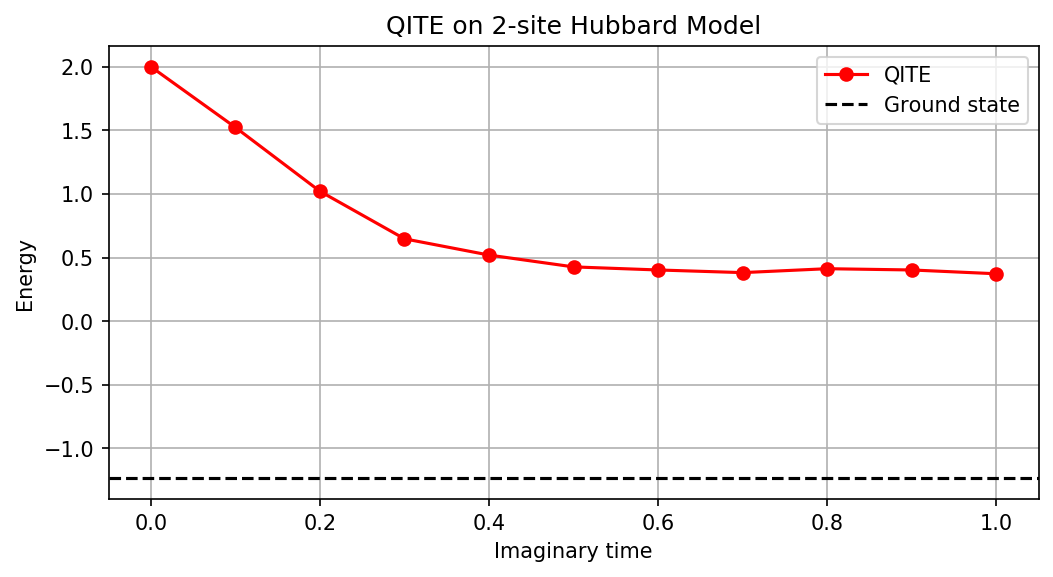

In [23]:
plot_E_list(E_list)

## Classical simulation

In [24]:
# Classical trajectory

# List to store energy values
energy_classical_list = []

# Initialize into |00...> state
init_state_as_list = [1] + [0] * (2**(nqbits) - 1)
psi = np.array(init_state_as_list,dtype=complex)
psi = psi/np.linalg.norm(psi)

# db = beta/N
expmH = expm(-db * Hamiltonian)
phi = psi

# Store the energy for initial wavefunction
e = np.matmul(Hamiltonian, phi)
e = np.real(np.matmul(np.transpose(np.conj(phi)), e))
energy_classical_list.append(e)

# Perform imaginary time evolution
for i in range(0,N):
    # Perform imaginary time evolution
    phi = np.matmul(expmH, phi)
    # Require normalization because imaginary time evolution is non-unitary
    phi = phi / np.linalg.norm(phi)
    # Store the energy values at each step
    e = np.matmul(Hamiltonian, phi)
    e = np.real(np.matmul(np.transpose(np.conj(phi)), e))
    energy_classical_list.append(e)
print('Final energy at beta', beta, 'is ', e)

Final energy at beta 1.0 is  -1.2165561126748219


## Classical QITE approximation

In [25]:
# QITE trajectory
energy_qite_list = []

phi = psi

# Store the energy for initial wavefunction
e = np.matmul(Hamiltonian, phi)
e = np.real(np.matmul(np.transpose(np.conj(phi)), e))
energy_qite_list.append(e)

debug_Pmu_expectation_list = []

dim = 4**nqbits

print('We start QITE now')
for i in range(0,N):
    
    # First construct Pmu_expectation matrices
    Pmu_expectation = np.zeros([dim], dtype=complex)
    for Pmu in range(2**4):
        ops = Int2Bas(Pmu, 4, 2)
#         print("ops: ", ops)
        operator = np.kron(sigma[:, :, ops[0]], sigma[:, :, ops[1]])
        Pmu_expectation[Pmu] = np.matmul(np.transpose(np.conj(phi)), np.matmul(operator, phi))
    debug_Pmu_expectation_list.append(Pmu_expectation.real.tolist())

    # Now construct S matrix
    S = np.zeros([dim, dim], dtype=complex)
    for i in range(dim):
        for j in range(dim):
            S[i,j] = Pmu_expectation[index[i, j]]*coeff[i, j]

    # Now construct b vector
    b = np.zeros([dim], dtype=complex)
    c = 1

    # We will hardcode in the QITE step
    
    for k in range(len(hm_list)):
        hm = hm_list[k]
        for j in range(len(hm)):
            pauli_pair = (hm[j][0][0],hm[j][0][1])
            idx = pauli_pair_dict[pauli_pair]
            c -= 2 * (db) * hm[j][1][0] * Pmu_expectation[idx]
    c = np.sqrt(c)
    
    for i in range(dim):
        b[i] += (Pmu_expectation[i] / c - Pmu_expectation[i]) / (db)
        for k in range(len(hm_list)):
            hm = hm_list[k]
            for j in range(len(hm)):
                pauli_pair = (hm[j][0][0],hm[j][0][1])
                idx = pauli_pair_dict[pauli_pair]
                b[i] -= hm[j][1][0] * coeff[i, idx] * Pmu_expectation[index[i, idx]] / c
        b[i] = 1j * b[i] - 1j * np.conj(b[i])

    # Obtain x 
    dalpha = np.eye(dim) * 0.1
    x = np.linalg.lstsq(S + np.transpose(S) + dalpha, -b, rcond=-1)[0]

    # Classical evolution
    U = np.eye(2**nqbits)
    for i in range(len(x)):
        ops = Int2Bas(i, 4, 2)
        operator = np.kron(sigma[:, :, ops[0]], sigma[:, :, ops[1]])
        U = np.matmul(expm(1j * (db) * x[i] * operator), U)
    phi = np.matmul(U, phi)
    
    e = np.matmul(Hamiltonian, phi)
    e = np.real(np.matmul(np.transpose(np.conj(phi)), e))
    energy_qite_list.append(e)

# print(debug_Pmu_expectation_list)
print('Final energy at beta', beta, 'is ', e)

We start QITE now
Final energy at beta 1.0 is  -1.2198839097994172


/home/abao/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


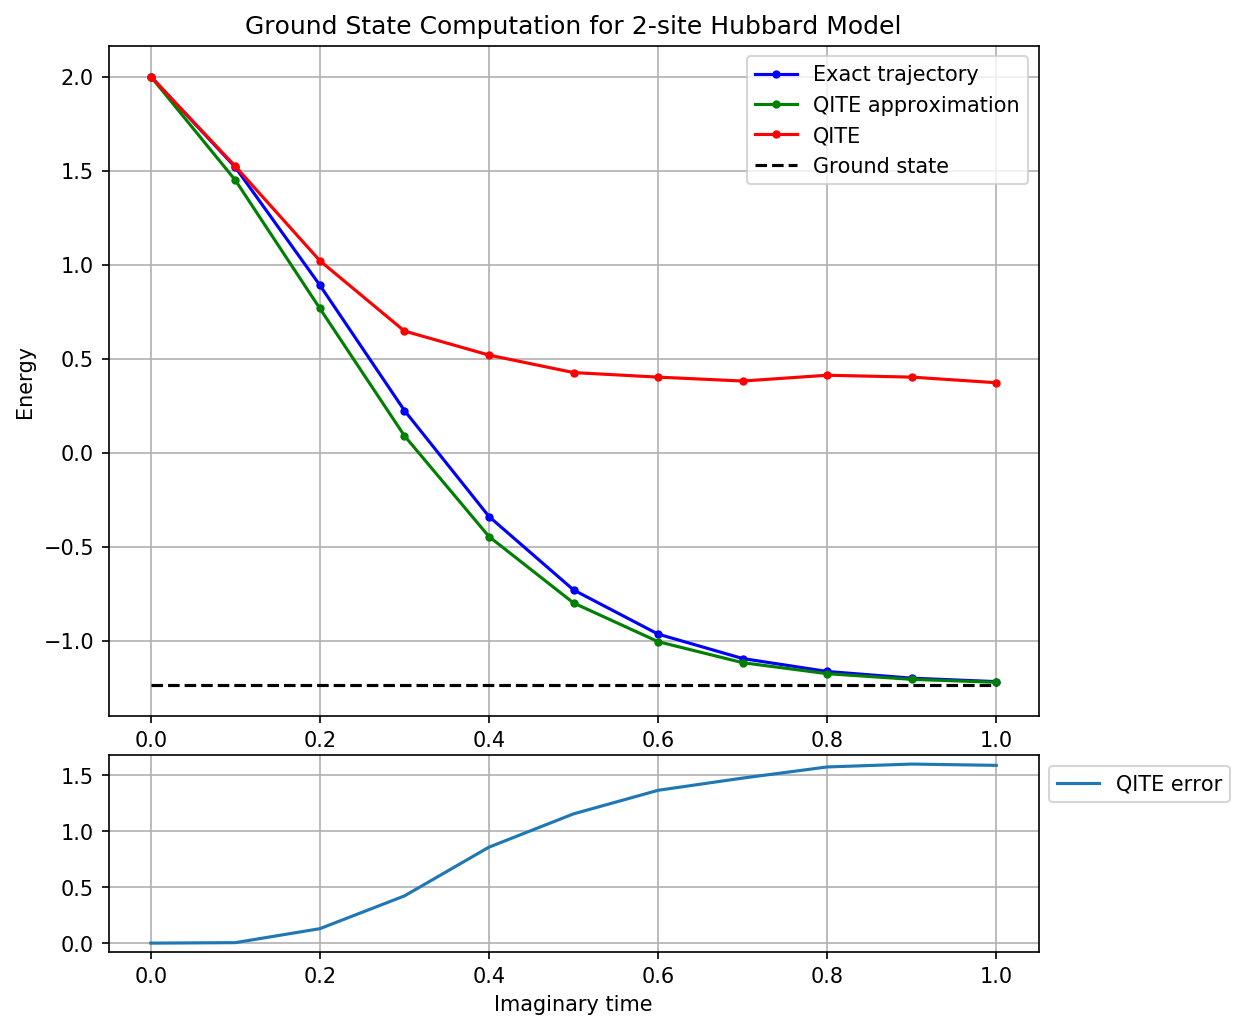

In [26]:
# plt.figure(figsize=(8,4))
        
beta_list = np.asarray(range(0, N+1)) * db
error = np.sqrt((np.array(E) - np.array(energy_classical_list))**2)

plt.figure(figsize=[8,8], dpi=150)
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1, sharex=ax1)    

ax1.plot(beta_list, energy_classical_list, '-b.', label='Exact trajectory')
ax1.plot(beta_list, energy_qite_list, '-g.', label='QITE approximation')
ax1.plot(np.arange(0,N+1)*db,np.average(E_list,axis=0),'-r.',label='QITE')
ax1.plot([beta_list[0], beta_list[-1]], [w[0], w[0]], '--k', label='Ground state')
# ax1.axhline(y=w[0], color='k',linestyle='--',label="Ground state")

ax2.plot(beta_list, error, label="QITE error")

ax1.set_title("Ground State Computation for 2-site Hubbard Model")
ax1.set_xlabel("Imaginary time")
ax1.set_ylabel("Energy")
ax1.legend(bbox_to_anchor=(1.0,1.0))
ax1.grid()

ax2.legend(bbox_to_anchor=(1.0,1.0))
ax2.set_xlabel("Imaginary time")
ax2.grid()
plt.show()